# Load Image and Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import preprocessing
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import backend as K
from scipy.stats import ttest_ind

from PIL import Image, ImageDraw
import requests
from io import BytesIO
import os
import pandas as pd

from notebooks_util import * 

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
model = MobileNetV2(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
path = 'data/grass_images'
images = list()
images_2 = list()
for file in os.listdir(path):
    img = Image.open(os.path.join(path, file))
    img = img.resize((224, 224))
    images.append(img)
    
    img_2 = img.copy()
    draw = ImageDraw.Draw(img_2)
    draw.ellipse((30, 30, 80, 80), fill='brown')
    images_2.append(img_2)
    
def prep(img):
    x = preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

img_array = np.concatenate([prep(img) for img in images])
img_array_2 = np.concatenate([prep(img) for img in images_2])

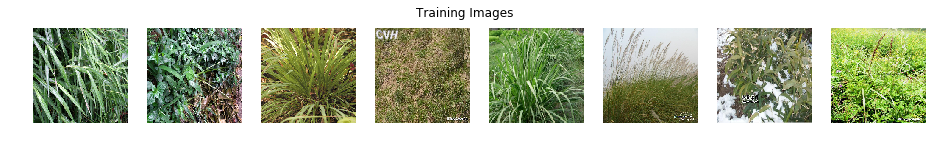

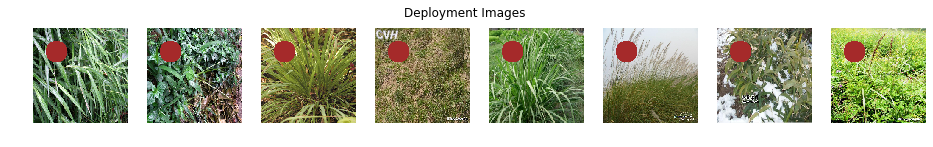

In [95]:
n_show = 8

# Show some examples.
_, ax = plt.subplots(1,n_show, figsize=[16, 2])
plt.suptitle('Training Images')
for i in range(n_show):
    ax[i].imshow(images[i], cmap='gray')
    ax[i].set_axis_off()
    
_, ax = plt.subplots(1,n_show, figsize=[16, 2])
plt.suptitle('Deployment Images')
for i in range(n_show):
    ax[i].imshow(images_2[i], cmap='gray')
    ax[i].set_axis_off()

In [142]:
def prep(img):
    x = preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def get_predicted_class_name(mdl, img):
    x = prep(img)
    preds = mdl.predict(x)
    return f'{decode_predictions(preds, top=1)[0][0][1]} ({str(np.argmax(preds))})'

In [143]:
predicted_classes = [get_predicted_class_name(model, img) for img in images]
predicted_classes_2 = [get_predicted_class_name(model, img) for img in images_2]

In [144]:
pd.DataFrame({'Training classes': predicted_classes, 'Deployed classes': predicted_classes_2})

,Training classes,Deployed classes
0,pineapple (953),ping-pong_ball (722)
1,cardoon (946),mushroom (947)
2,pineapple (953),coral_fungus (991)
3,maze (646),hay (958)
4,ear (998),ping-pong_ball (722)
5,valley (979),balloon (417)
6,pot (738),pot (738)
7,water_snake (58),croquet_ball (522)
8,golf_ball (574),golf_ball (574)
9,hay (958),hay (958)


In [145]:
img_array = np.concatenate([prep(img) for img in images])
img_array_2 = np.concatenate([prep(img) for img in images_2])

In [146]:
def get_logits(mdl, x):
    preds = mdl.predict(x)
    return preds

In [147]:
logits = get_logits(model, img_array)
logits_2 = get_logits(model, img_array_2)

In [160]:
mean_diff = np.mean(logits_2, axis=0) - np.mean(logits, axis=0)
differences = np.argsort(mean_diff)[::-1]
most_significant_differences = differences[:5]
print(most_significant_differences)
print(np.sort(mean_diff)[::-1][:5])

[958 722 417 522 574]
[0.07216422 0.06854372 0.05692183 0.0561954  0.03109907]


In [162]:
def get_t_test_indices(logits1, logits2):
    return ttest_ind(logits1, logits2)[1]

In [169]:
p_values = get_t_test_indices(logits, logits_2)
ordered_p_values = np.argsort(p_values)
most_significant = ordered_p_values[:10]
print(most_significant)
print(np.sort(p_values)[:10])

[430 193 879 933 982 852 712 667 629 714]
[0.00012947 0.00014706 0.00016309 0.00017323 0.00021138 0.00022835
 0.00030495 0.0005632  0.00057648 0.00070108]


# Gradients

### Saliency Map

In [219]:
def get_saliency_tensor(mdl, indices=None):
    if indices is None:
        output_tensor = mdl.output
    else:
        output_tensor = tf.gather(mdl.output, indices, axis=1)
    input_tensor = mdl.input
    gradient = K.gradients(output_tensor, input_tensor)
    return gradient

def get_saliency_map(saliency_tensor, img_as_array):
    sess = tf.InteractiveSession()
    sess.run(tf.initialize_all_variables())
    evaluated_gradients = sess.run(saliency_tensor, feed_dict={model.input:img_as_array})
    sess.close()
    flat_gradients = evaluated_gradients[0].max(axis=-1)  # take the max over the channels
    flat_gradients = (flat_gradients.T-flat_gradients.T.min(axis=0))/(flat_gradients.T.max(axis=0) - flat_gradients.T.min(axis=0))
    flat_gradients = flat_gradients.T
    return flat_gradients

### Plot results

##### All Outputs

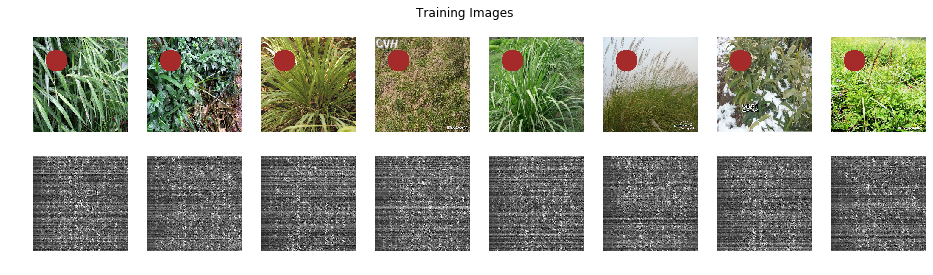

In [223]:
saliency_tensor = get_saliency_tensor(model)
gradients_2 = get_saliency_map(saliency_tensor, img_array_2)

n_show = 8

# Show some examples.
_, ax = plt.subplots(2, n_show, figsize=[16, 4])
plt.suptitle('Training Images')
for i in range(n_show):
    ax[0, i].imshow(images_2[i],)
    ax[0, i].set_axis_off()

    ax[1, i].imshow(gradients_2[i], cmap='gray')
    ax[1, i].set_axis_off()

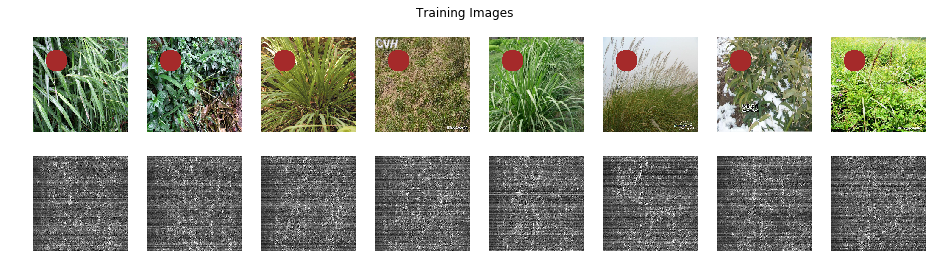

In [224]:
saliency_tensor = get_saliency_tensor(model, most_significant_differences)
gradients_2 = get_saliency_map(saliency_tensor, img_array_2)

n_show = 8

# Show some examples.
_, ax = plt.subplots(2, n_show, figsize=[16, 4])
plt.suptitle('Training Images')
for i in range(n_show):
    ax[0, i].imshow(images_2[i],)
    ax[0, i].set_axis_off()

    ax[1, i].imshow(gradients_2[i], cmap='gray')
    ax[1, i].set_axis_off()

# Convolution Filter Visualization

In [36]:
# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
LAYER_NAME = 'block5_conv1'

# build the VGG16 network with ImageNet weights
vgg = vgg16.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')
vgg.summary()

Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0      

In [38]:
# example function call
img = visualize_layer(vgg, LAYER_NAME, filter_list=[0])

Costs of filter   0:   401 ( 124.19s )
1 filter processed.


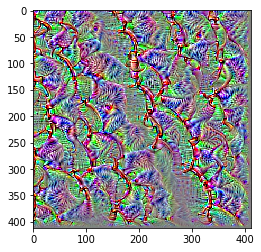

In [39]:
plt.imshow(img)

# Mean Activations

In [4]:
LAYER_NAME = 'block5_conv1'

# build the VGG16 network with ImageNet weights
vgg = vgg16.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')
vgg.summary()

Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0      

In [28]:
mean_activations_all_filters = get_mean_activation_of_layer(vgg, LAYER_NAME, img_array)

Compute filters 0 to 512


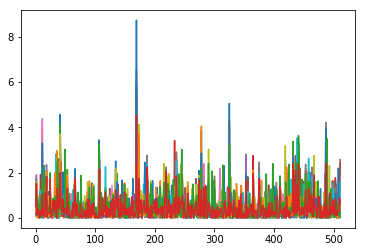

In [29]:
plt.plot(mean_activations_all_filters);

In [26]:
mean_activations_all_filters_2 = get_mean_activation_of_layer(vgg, LAYER_NAME, img_array_2)

Compute filters 0 to 512


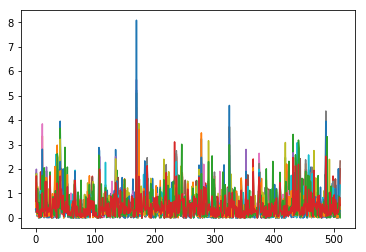

In [27]:
plt.plot(mean_activations_all_filters_2);

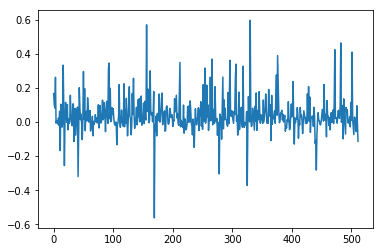

In [34]:
plt.plot(np.mean(mean_activations_all_filters_2, axis=1) - np.mean(mean_activations_all_filters, axis=1))